In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mplleaflet
%matplotlib inline
plt.style.use('seaborn')
sns.set_palette(sns.color_palette("Set1", n_colors=7, desat=0.7))

# Importing Data

We will only look at crime from 2010-2017 as 2018 is not complete yet.

In [2]:
c = pd.read_csv('../Data/crime_data_clean.csv', index_col='time', parse_dates=True)
c = c[c.year != 2018]
c.head()

,code,description,disposition,location,patrol_zone,landmark,lat,long,year,month,...,inc_15_25,inc_25_35,inc_35_50,inc_50_75,inc_75_100,inc_100_150,inc_150_200,inc_greater_200,inc_median,inc_mean
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:36:00,7399,Miscellaneous Offenses,NaN,NONCAM,Z4,NaN,33.773124,-84.403163,2010,1,...,18772.0,18419.0,21725.0,26366.0,16067.0,18490.0,8005.0,14504.0,45171.0,79299.0
2010-01-01 01:55:00,7399,Miscellaneous Offenses,NaN,ONCAMRES,Z1,Center Street Apartments North,0.000000,0.000000,2010,1,...,18772.0,18419.0,21725.0,26366.0,16067.0,18490.0,8005.0,14504.0,45171.0,79299.0
2010-01-01 02:00:00,2308,Larceny - From Building,NaN,NONCAM,Z2,Sigma Nu Fraternity,33.775556,-84.394180,2010,1,...,18772.0,18419.0,21725.0,26366.0,16067.0,18490.0,8005.0,14504.0,45171.0,79299.0
2010-01-01 12:00:00,2204,Burglary - No Forced Entry - Residence,Unfounded,ONCAMRES,Z2,North Avenue Apartments North Building,33.771292,-84.391332,2010,1,...,18772.0,18419.0,21725.0,26366.0,16067.0,18490.0,8005.0,14504.0,45171.0,79299.0
2010-01-02 06:15:00,7399,Miscellaneous Offenses,NaN,ONCAM,Z2,North Avenue Apartments,33.771292,-84.391332,2010,1,...,18772.0,18419.0,21725.0,26366.0,16067.0,18490.0,8005.0,14504.0,45171.0,79299.0


# Crime by Location

In [3]:
#making a df with all the unique locations crimes have occurred
map_df = c[(c.long!=0)&(c.lat!=0)].drop_duplicates(subset=['lat', 'long'])#.iloc[:500]

#plotting on a map by patrol zone
fig = plt.figure(figsize=(5,8))
for zone, group in map_df.groupby('patrol_zone'):
    plt.plot(group.long, group.lat, ls='', marker='D', markersize=10)
    
mplleaflet.display(fig = fig)

NOTE: The above interactive map may not render on GitHub. If so, it can be viewed here:

https://nbviewer.jupyter.org/github/pspratling/GT-Crime-Data-Analysis/blob/master/Project/Exploratory%20Data%20Analysis.ipynb

Clearly over the years, crime has occurred almost everywhere on and around campus. But are some locations safer than others? Let's find out which crimes are more prevalent in different locations on and around campus.

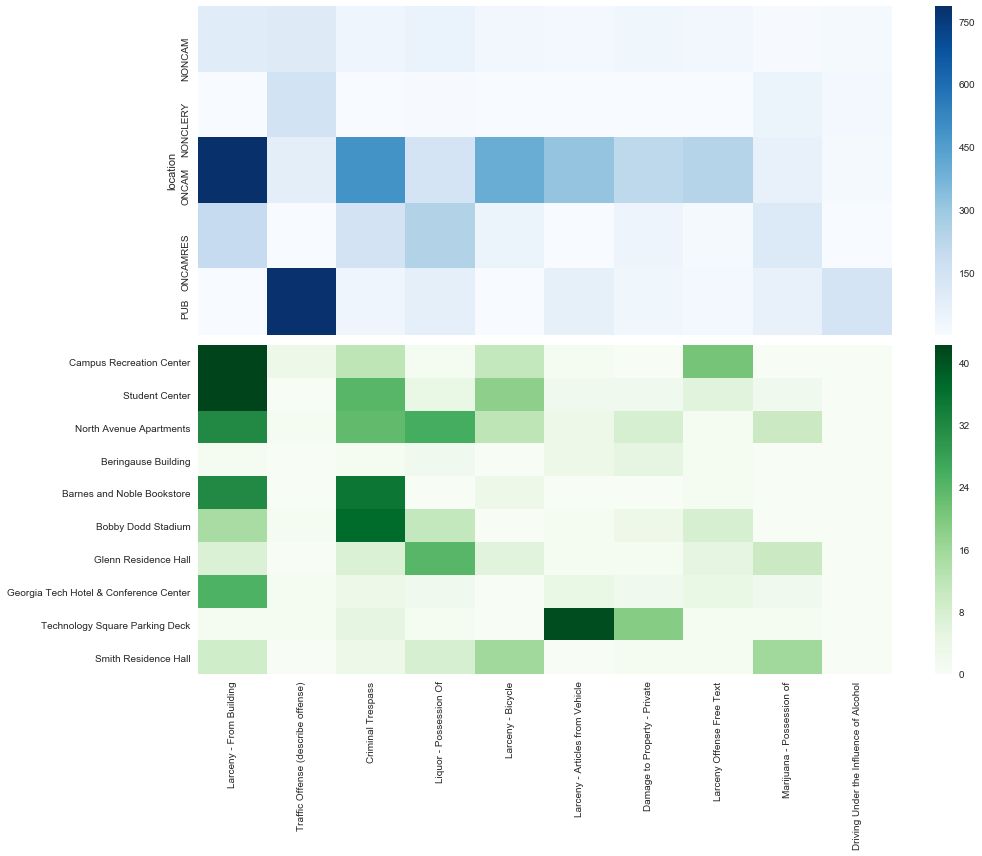

In [4]:
#finding top 10 most frequent crimes and landmarks (excluding miscellaneous offenses)
top_crimes = c['description'].value_counts()[1:11].index
top_landmarks = c['landmark'].value_counts()[:10].index

#grouping c and reshaping for analysis
crime_location = c.groupby(['location', 'description']).size().unstack().fillna(0)
crime_landmark = c.groupby(['landmark', 'description']).size().unstack().fillna(0)
#filtering by most common crimes and landmarks
crime_location = crime_location.loc[:, top_crimes]
crime_landmark = crime_landmark.loc[top_landmarks, top_crimes]

#plotting heatmaps
fig, axes = plt.subplots(2, 1, figsize=(15, 12))   
sns.heatmap(crime_location, cmap='Blues', ax=axes[0], robust=True, xticklabels=False)
sns.heatmap(crime_landmark, cmap='Greens', ax=axes[1], robust=True)
axes[0].set_xlabel('')
plt.tight_layout()
plt.show()

It seems that most crimes are being reported on campus as opposed to in the surrounding areas or in residential areas. Larceny is very prevalent throughout campus, happening frequently in the Student Center and the CRC in particular. The absence of the CULC is interesting to note - despite being one of the most popular locations for students to be on campus, it is not even in the top 10 highest locations for crime. This could be because of the active security guards always on location.

Larceny from vehicle and damage to property appears to be overwhelmingly in the Tech Square Parking Deck as opposed to the many other parking locations on campus. This might be because of the public access to this parking deck. It may be a good idea to choose another location to park on campus, even if this one is conveniently located.

Residential areas seem to be fairly safe. Larceny and criminal trespass seem to occur occasionally, but the most frequent crime occurring in these areas appears to be illegal possession of drugs (alcohol and marijuana).

# Temporal Crime Trends

How has the overall level of crime changed over the years? What is the relationship between crime and time of day? By the day of week? By quarter or semester?

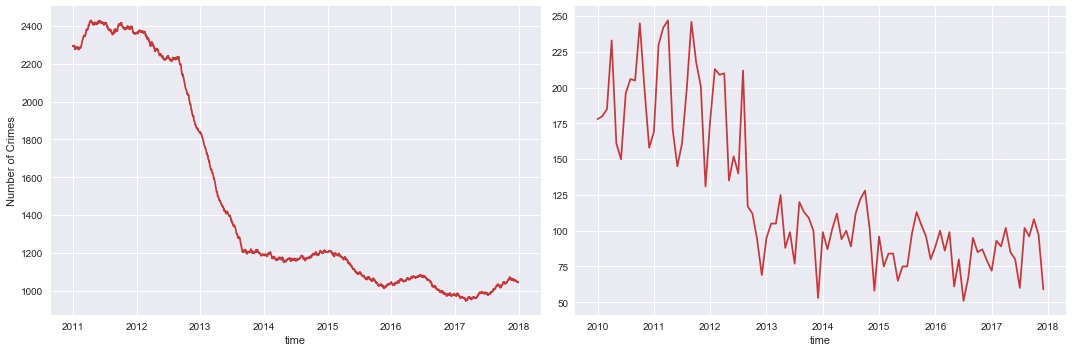

In [5]:
#plotting year long rolling average of number of crimes and number of crimes per month
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
c.resample('D').size().rolling(365).sum().plot(ax=ax[0])
c.resample('M').size().plot(ax=ax[1])
ax[0].set_ylabel('Number of Crimes')
plt.tight_layout()
plt.show()

Overall levels of crime have clearly decreased over time. There is also clearly some major periodicity as shown in the right chart that implies that seasonality plays a large role in number of crimes. 

The major decrease in total number of crimes sometime between 2012 and 2014 is very interesting. This is something we will want to investigate later.

It might be interesting to see how individual types of crime have changed over the years and throughout the day.

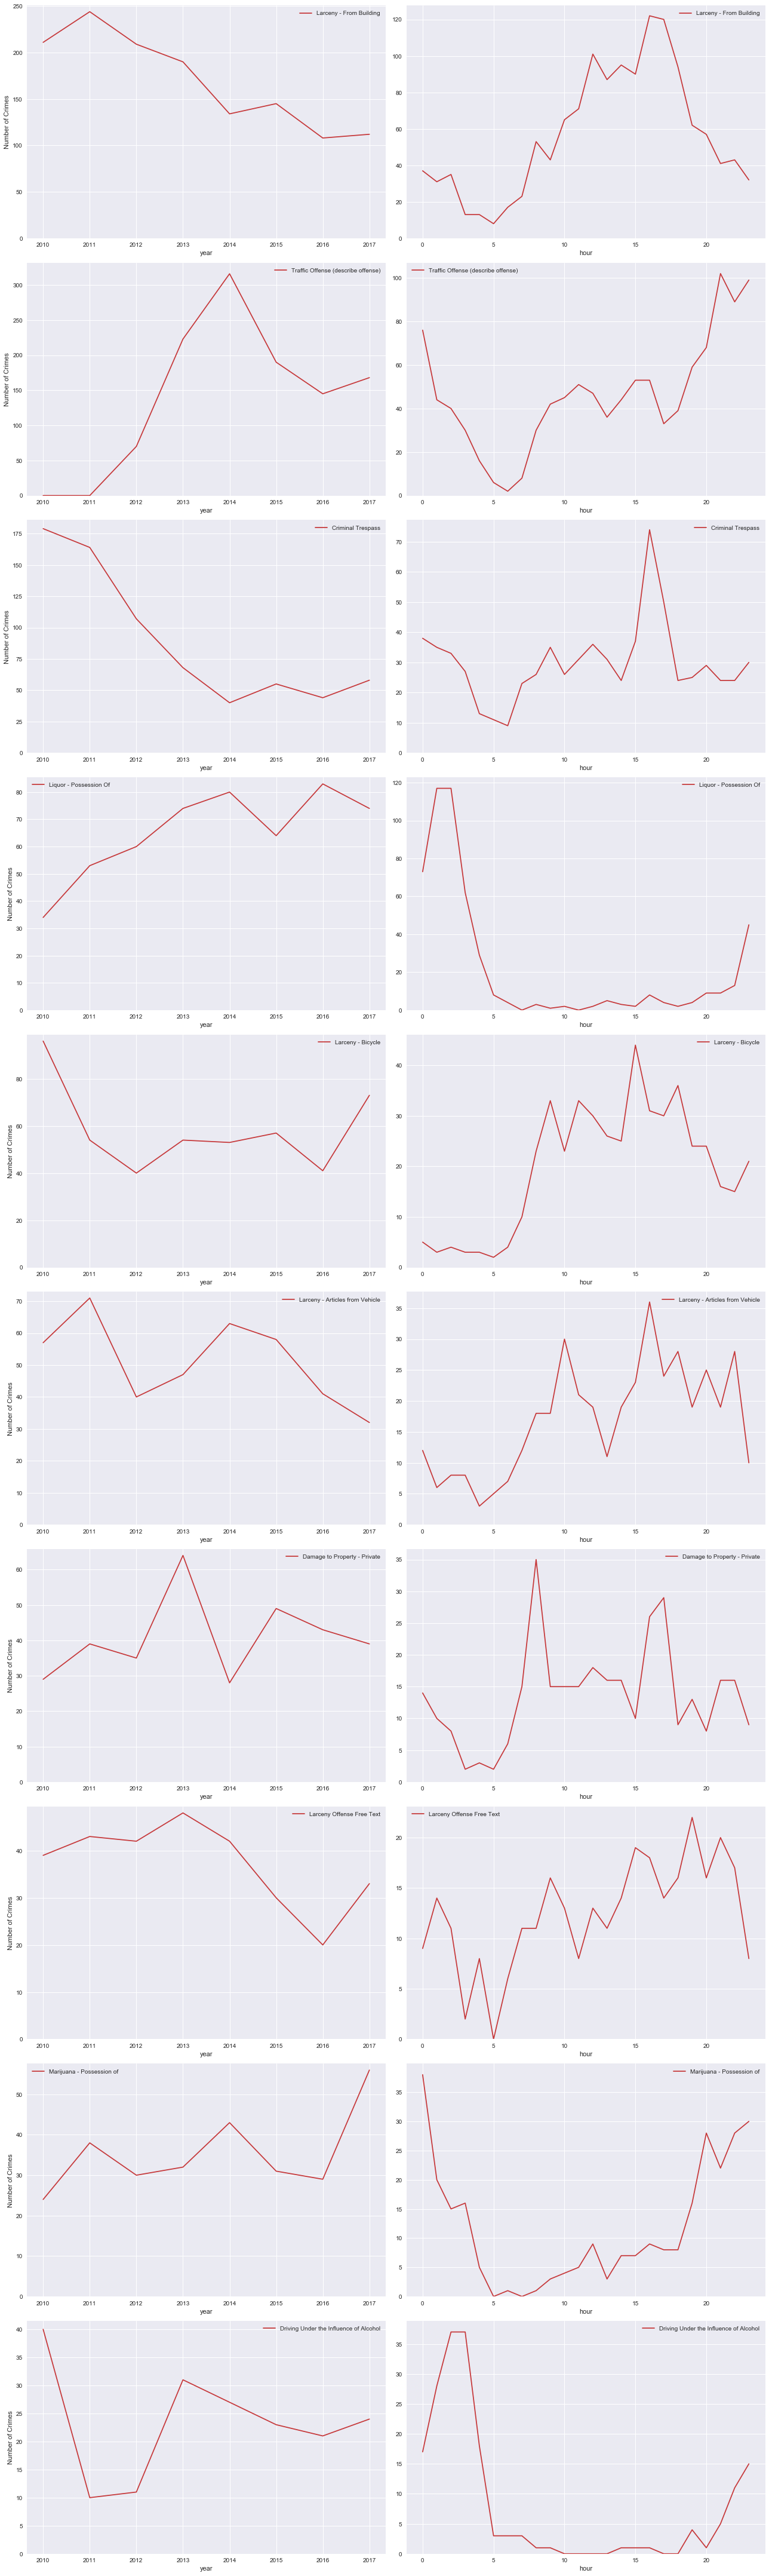

In [6]:
fig, ax = plt.subplots(10, 2, figsize=(18,60))
#grouping by top crimes and time
crime_year = c.groupby(['description', 'year']).size().unstack().fillna(0)
crime_hour = c.groupby(['description', 'hour']).size().unstack().fillna(0)
crime_year = crime_year.loc[top_crimes]
crime_hour = crime_hour.loc[top_crimes]

#plotting each crime side-by-side:
#left: crime trend over the year
#right: crime trend through the day
for i in range(10):
    crime_year.iloc[i].plot(ax=ax[i, 0], legend=True)
    crime_hour.iloc[i].plot(ax=ax[i, 1], legend=True)
    ax[i, 0].set_ylim(ymin=0)
    ax[i, 1].set_ylim(ymin=0)
    ax[i, 0].set_ylabel('Number of Crimes')
    
plt.tight_layout()
plt.show()

Larceny and criminal trespass have clearly gone down throughout the years. Other crimes such as possession of liquor and driving under the influence of alcohol appear to have remained fairly consistent.

It is also interesting to see that larceny and criminal trespass appear to peak sometime in the mid afternoon, whereas DUI's and crimes that are likely to occur in residences (possession of liquor/marijuana) seem to bes highest in the late night/early morning.

Let's look how overall crime rates change by time of day/ year/ week.

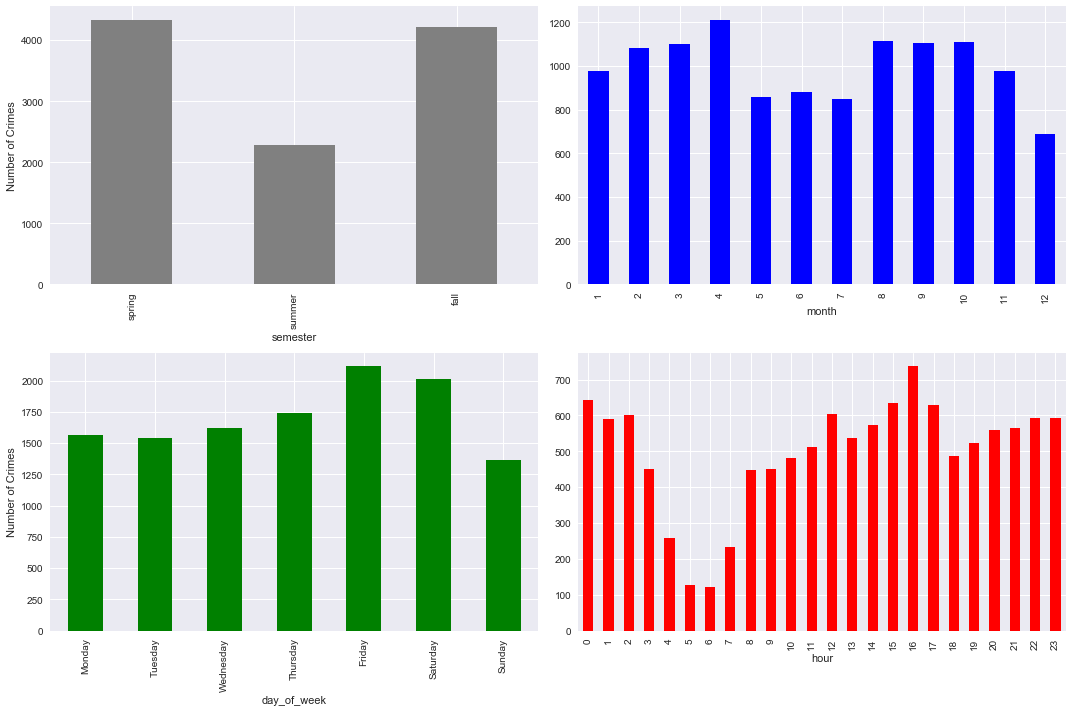

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
#grouping and plotting
c.groupby('semester').size().plot(kind='bar', ax=ax[0, 0], color='gray')
c.groupby('month').size().plot(kind='bar', ax=ax[0, 1], color='b')
c.groupby('day_of_week').size().plot(kind='bar', ax=ax[1, 0], color='g')
c.groupby('hour').size().plot(kind='bar', ax=ax[1, 1], color='r')

#formatting plot
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
semester_names = ['spring', 'summer', 'fall']
ax[0, 0].set_xticklabels(semester_names)
ax[1, 0].set_xticklabels(dow_names)
ax[0, 0].set_ylabel('Number of Crimes')
ax[1, 0].set_ylabel('Number of Crimes')
plt.tight_layout()

Crimes clearly decrease as a result of less students being on campus. This is shown in the decrease in crimes in May-July during the summer semester, as well as in December when many students go home for winter break.

Crimes seem to peak on Friday and Saturday, with the weekdays being fairly consistent and Sunday having the least amount. Crimes also have a major decrease in the early morning around 4-7, and are fairly consistent throughout the evening and late night.

Let's try to find out if crime distribution throughout the day differs by day of week.

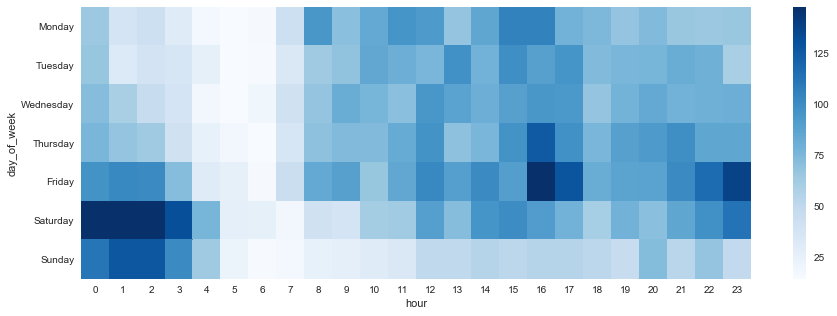

In [8]:
#grouping and reshaping
dow_hour = c.groupby(['day_of_week', 'hour']).size().unstack()

#plotting
plt.figure(figsize=(15,5))
sns.heatmap(dow_hour, cmap='Blues', robust=True, yticklabels=dow_names)
plt.show()

Clearly crimes on the weekend tend to happen later at night than on the weekdays. What's interesting to see is thatthe majority of Sunday's crimes are in the late night, i.e. from Saturday after midnight. Once Sunday morning comes, the crimes appear to stay low for the rest of the day, making Sunday the safest day by far.

# Crimes by Semester

Since we will be predicting crimes by semester, we should look a little deeper in how the number changes per semester. How do crimes vary by semester? What statistics correlate strongly with crimes per semester? Does crimes per semester have significant autocorrelation?

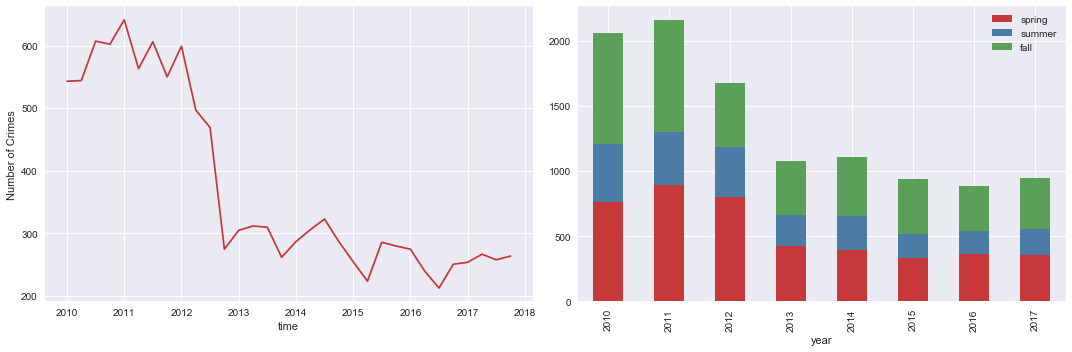

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

c.resample('Q').size().plot(ax=ax[0])
semester_size = c.groupby(['year', 'semester']).size()
semester_size.unstack().plot(kind='bar', stacked=True, ax=ax[1])
ax[0].set_ylabel('Number of Crimes')
ax[1].legend(semester_names)

plt.tight_layout()
plt.show()

Despite the general decrease in crime, the distribution of crimes between semesters seems to stay roughly the same year after year. The spring and fall semesters have about equal amounts of crime, whereas the summer semester seems to have about half as much as the other semesters. This could be because of the reduced amount of students on campus during the summer as well as the fact that the summer semester is only 12 weeks long, while the other two are 16 weeks long.

Let's look into average crimes per week by semester to see how much of this difference is because of the length of the semester.

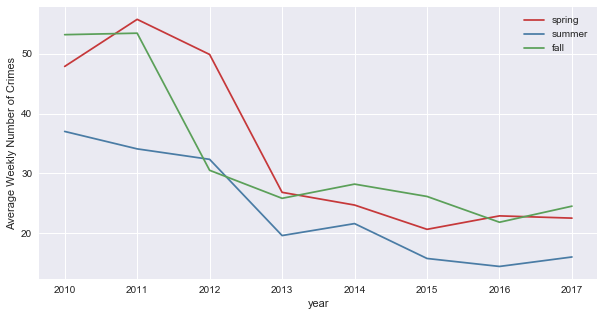

In [10]:
semester_weekly = semester_size.unstack()
semester_weekly.iloc[:, [0,2]] = semester_weekly.iloc[:, [0,2]].apply(lambda x: x/16)
semester_weekly.iloc[:, 1] = semester_weekly.iloc[:, 1].apply(lambda x: x/12)
semester_weekly.plot(figsize=(10,5))
plt.ylabel('Average Weekly Number of Crimes')
plt.legend(semester_names)
plt.show()

Looks like even when we control for semester length, summer has the least amount of crimes.

Let's look into correlations. What factors can we use to predict number of crimes per semester? We'll start with the autocorrelation of number of crimes per semester.

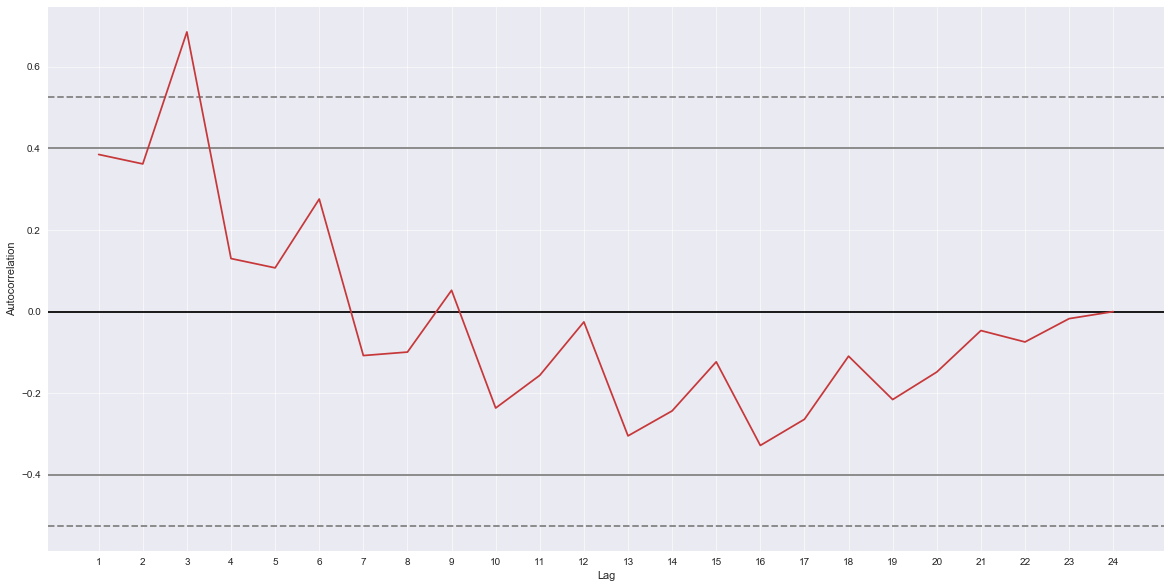

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
#plotting autocorrelation of crimes per semester
pd.plotting.autocorrelation_plot(semester_size, ax=ax)
plt.xticks(range(1, 25))
plt.grid(color='w', linestyle='-', alpha=0.6)

plt.show()

This is an interesting autocorrelation plot. It seems to spike in intervals of three, corresponding with the number of semesters per year. The solid grey horizontal line corresponds with a 95% confidence band in terms of significance that the autocorrelation is nonzero. The dashed grey line represents a 99% confidence band. In particular, the autocorrelation with a lag of 3 is very statistically significant, so we should use this as a predictor.

Let's now look at the correlations with other variables.

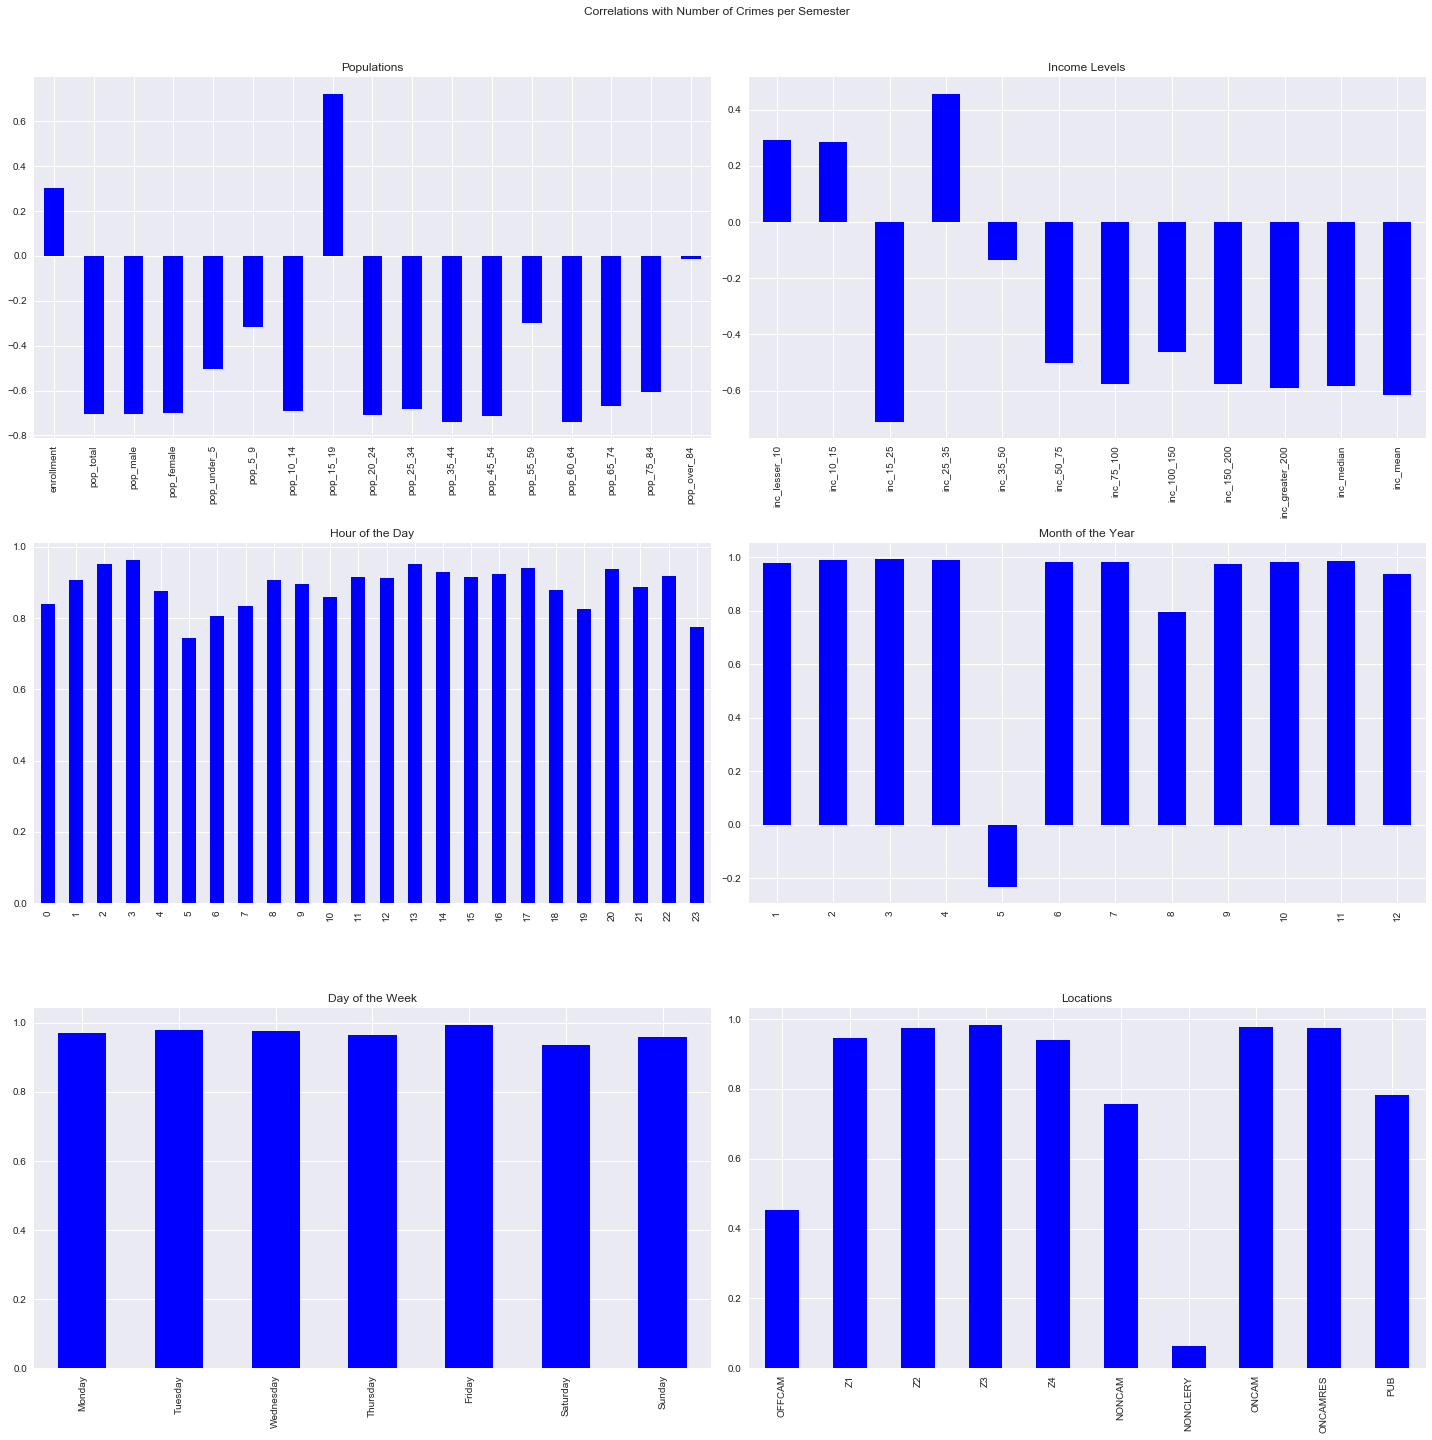

In [12]:
#takes as input the c dataframe: returns a series
#separates and aggregates categorical variables for correlations
def agg_categorical(c, col):
    agg = c.groupby(['year', 'semester', col]).size().unstack()
    return  agg


#finding values to be used for correlations
semester_means = c.groupby(['year', 'semester']).agg(np.mean)
semester_means['num_crimes'] = semester_size

#getting rid of irrelevant and categorical columns
semester_means = semester_means.iloc[:, 9:]

#concatenating means of noncategorical variables with sums of categorical variables
categorical_cols = ['hour', 'month', 'day_of_week', 'patrol_zone', 'location']
dfs = [semester_means] + [agg_categorical(c, col) for col in categorical_cols]
semester_totals = pd.concat(dfs, axis=1)

#finding final correlations
correlations = semester_totals.corr()['num_crimes'].drop('num_crimes')

#plotting
fig, ax = plt.subplots(3, 2, figsize=(20,21))
correlations.iloc[:17].plot(kind='bar', color='b', ax=ax[0,0], title='Populations')
correlations.iloc[17:29].plot(kind='bar', color='b', ax=ax[0,1], title='Income Levels')
correlations.iloc[29:53].plot(kind='bar', color='b', ax=ax[1,0], title='Hour of the Day')
correlations.iloc[53:65].plot(kind='bar', color='b', ax=ax[1,1], title='Month of the Year')
correlations.iloc[65:72].plot(kind='bar', color='b', ax=ax[2,0], title='Day of the Week')
correlations.iloc[72:].plot(kind='bar', color='b', ax=ax[2,1], title='Locations')

#fixing some labels
ax[2,0].set_xticklabels(dow_names)
plt.suptitle('Correlations with Number of Crimes per Semester')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
def apriori(df, col1, col2):
    """
    takes in the crime dataframe and two column names
    returns a dataframe with the order 2 apriori calculations
    indexed based on given column names
    """
    n = len(df)
    supports1 = df.groupby(col1).size()/n
    supports2 = df.groupby(col2).size()/n
    supports_combined = df.groupby([col1, col2]).size()/n
    confidences = {}
    lifts = {}
    
    for val1, val2 in supports_combined.index:
        s1 = supports1[val1]
        s2 = supports2[val2]
        sc = supports_combined[(val1, val2)]
        
        confidences[(val1, val2)] = sc / s1
        lifts[(val1, val2)] = sc / (s1*s2)
        
    confidences = pd.Series(confidences)
    lifts = pd.Series(lifts)
    associations = pd.concat([supports_combined, confidences, lifts], axis=1)
    associations.columns = ['support', 'confidence', 'lift']
    
    return associations


def plot_lift(df, ax, kind='line'):
    """
    takes in an associations dataframe output by apriori, matplotlib axes, and optional kind parameter
    plots the lift column
    returns matplotlib figure object
    """
    x = df.index.get_level_values(1)
    xlim = (x.min(), x.max())
    f = df['lift'].unstack(0).plot(kind=kind, xlim=xlim, ax=ax)
    if df.index.names[0] == 'semester':
        ax.legend(['spring', 'summer', 'fall'])
    ax.axhline(1, color='black')
    ax.set_ylabel('lift')
    return f

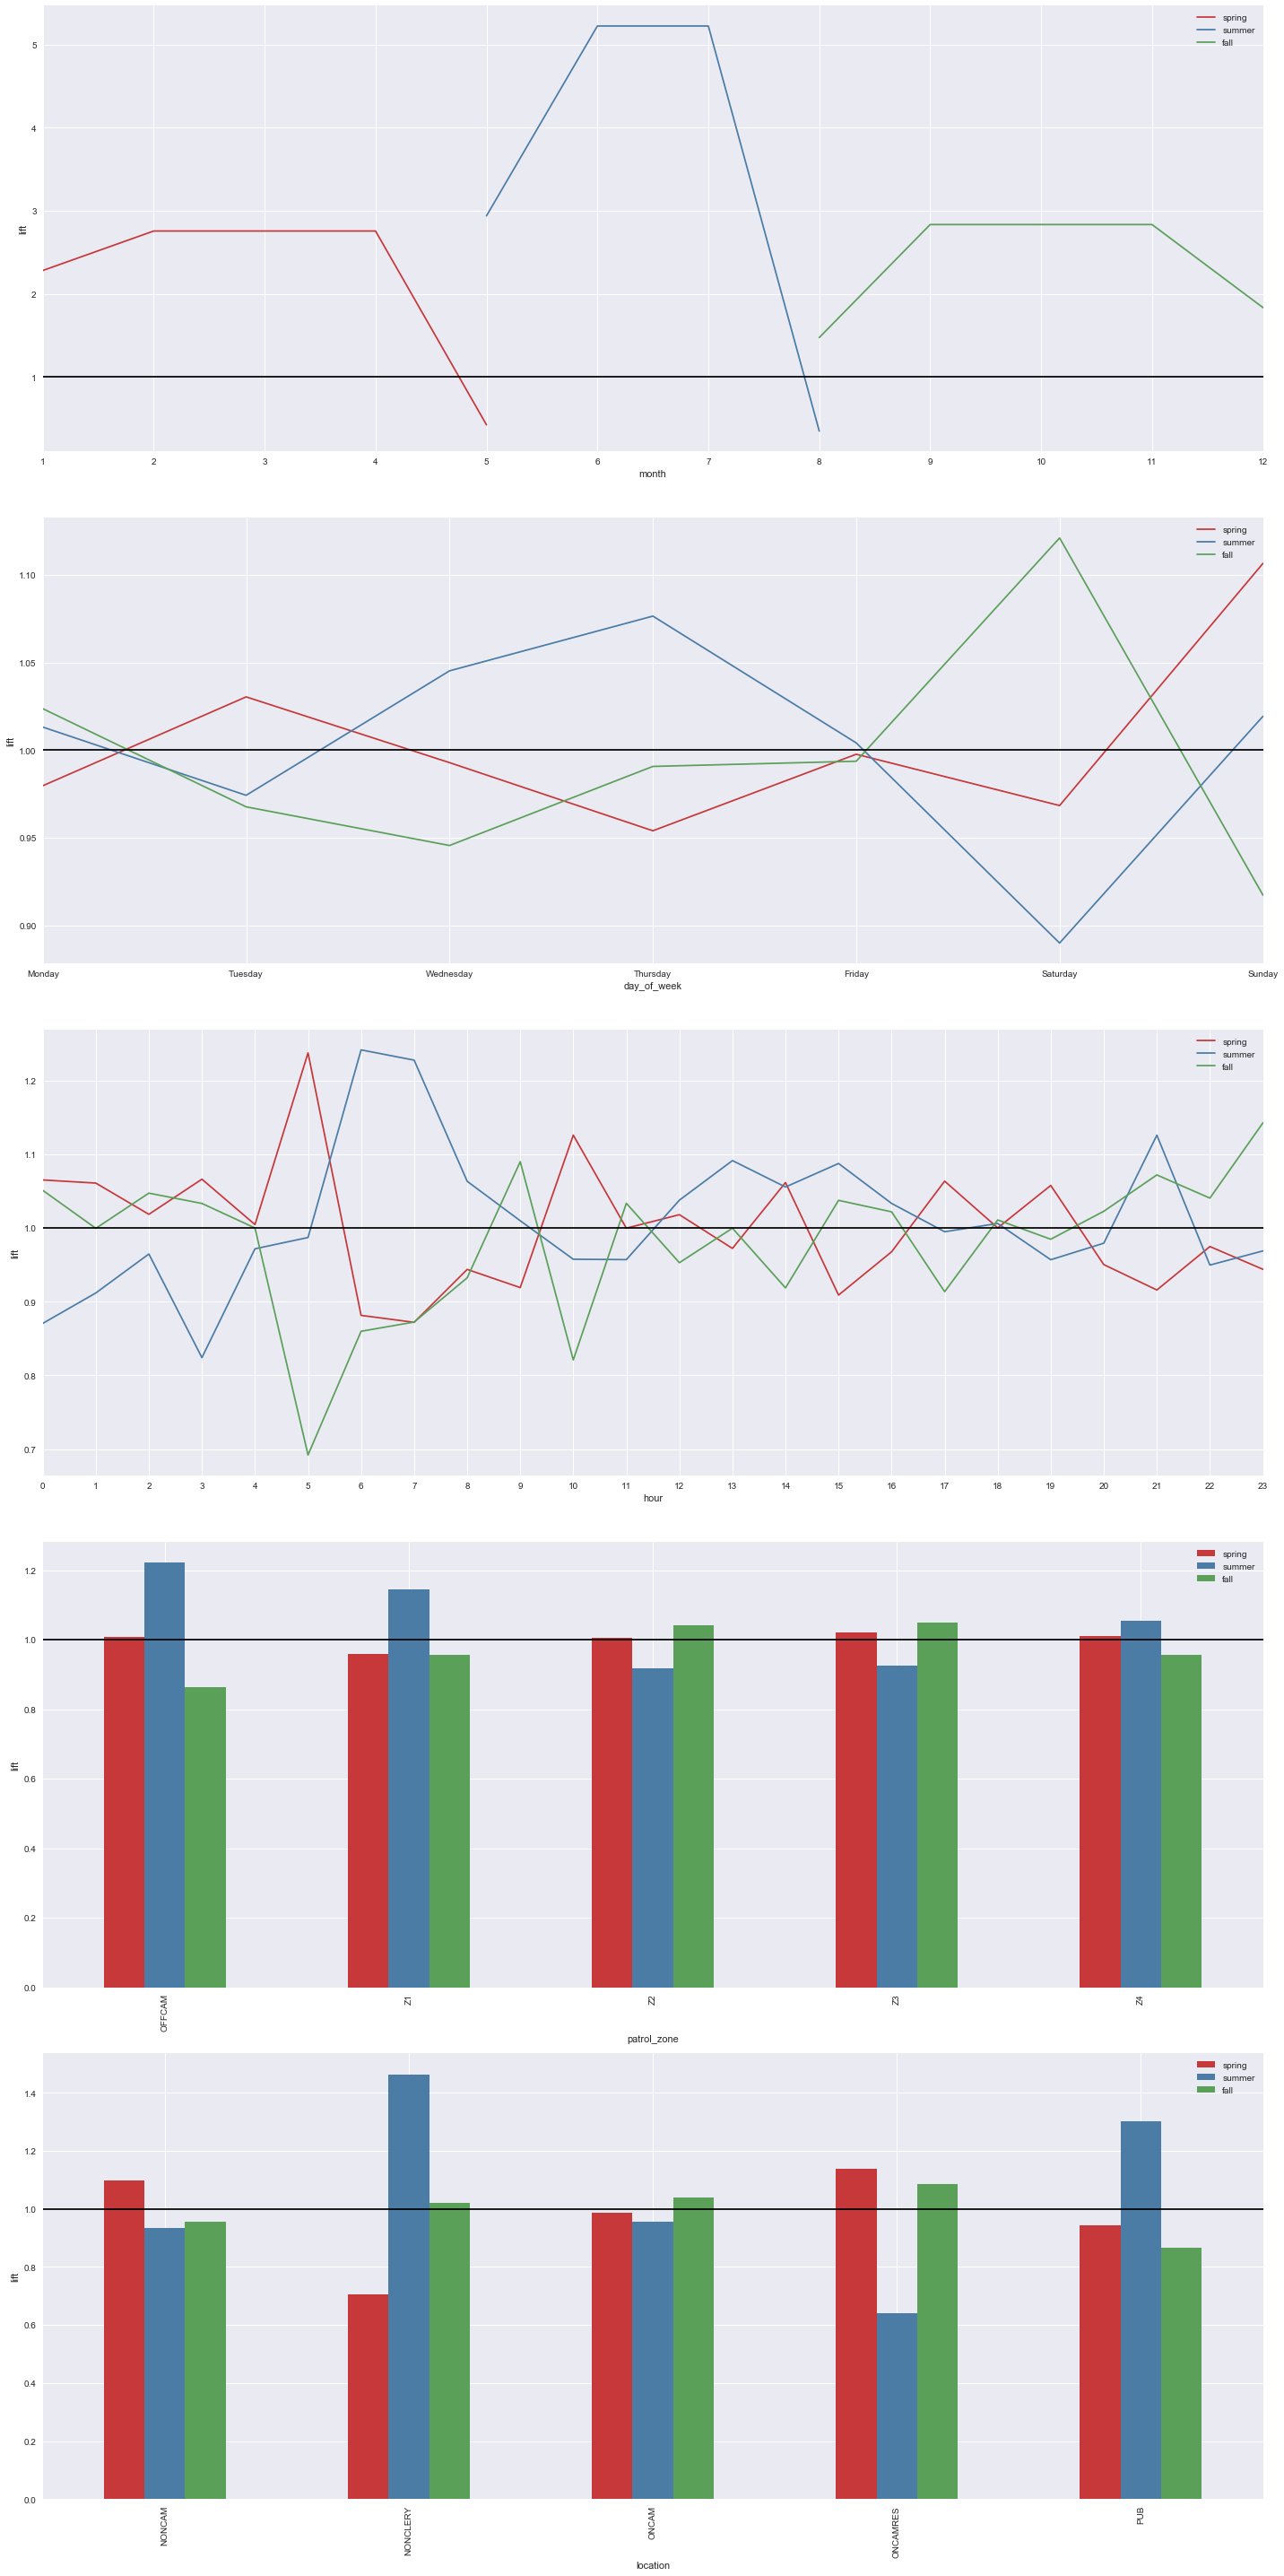

In [14]:
#plotting lift of apriori associations for semester to other variables
fig, ax = plt.subplots(5, 1, figsize=(20, 40))

plot_lift(apriori(c, 'semester', 'month'), ax=ax[0])
plot_lift(apriori(c, 'semester', 'day_of_week'), ax=ax[1])
plot_lift(apriori(c, 'semester', 'hour'), ax=ax[2])
plot_lift(apriori(c, 'semester', 'patrol_zone'), ax=ax[3], kind='bar')
plot_lift(apriori(c, 'semester', 'location'), ax=ax[4], kind='bar')

ax[0].set_xticks(range(1, 13))
ax[1].set_xticklabels(dow_names)
ax[2].set_xticks(range(24))

plt.tight_layout()
plt.show()

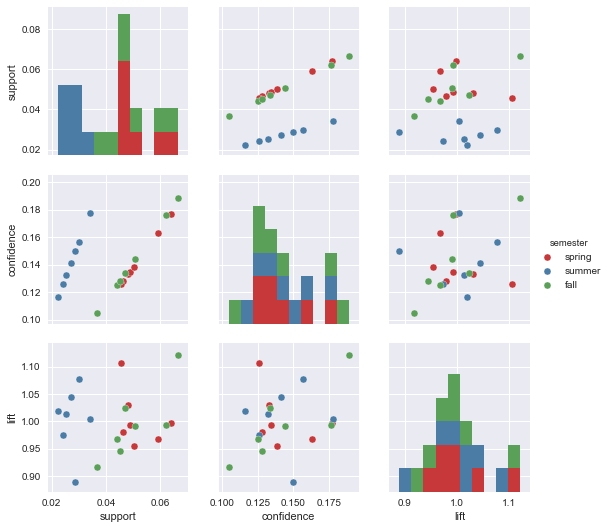

In [15]:
f = apriori(c, 'semester', 'day_of_week')
f = f.reset_index()
f['semester'] = f['semester'].map(dict(zip([0,1,2], semester_names)))
sns.pairplot(f, vars=['support', 'confidence', 'lift'], hue='semester')
plt.show()

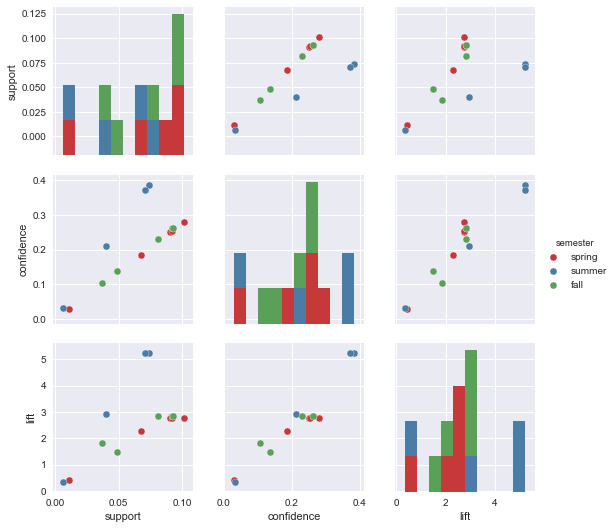

In [16]:
f = apriori(c, 'semester', 'month')
f = f.reset_index()
f['semester'] = f['semester'].map(dict(zip([0,1,2], semester_names)))
sns.pairplot(f, vars=['support', 'confidence', 'lift'], hue='semester')
plt.show()

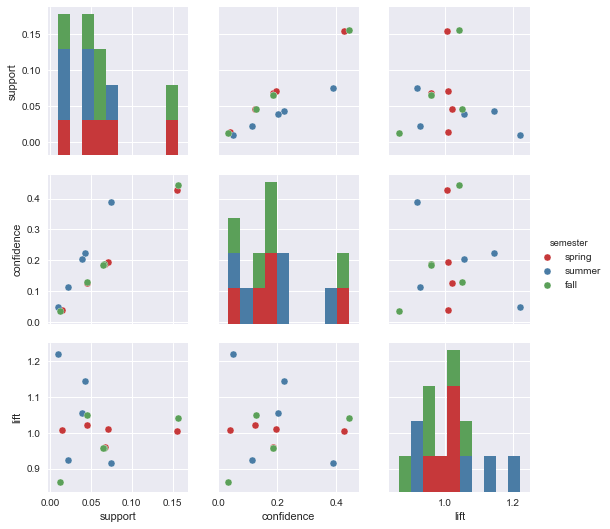

In [17]:
f = apriori(c, 'semester', 'patrol_zone')
f = f.reset_index()
f['semester'] = f['semester'].map(dict(zip([0,1,2], semester_names)))
sns.pairplot(f, vars=['support', 'confidence', 'lift'], hue='semester')
plt.show()

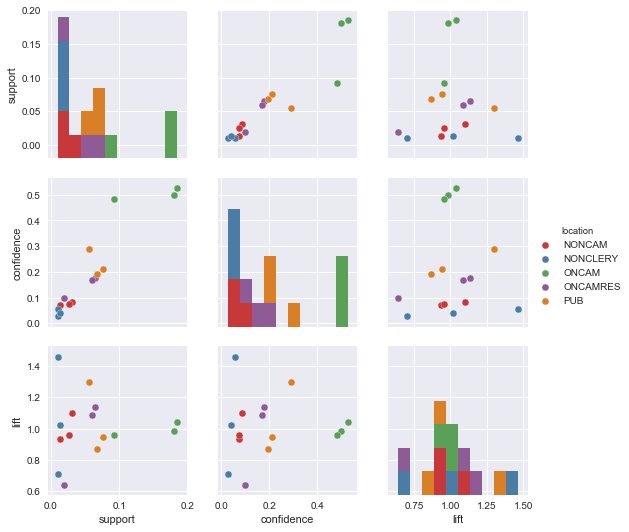

In [18]:
f = apriori(c, 'semester', 'location')
f = f.reset_index()
sns.pairplot(f, vars=['support', 'confidence', 'lift'], hue='location')
plt.show()